# Options

In [226]:
import pandas as pd
import numpy as np
from keras.callbacks import EarlyStopping
from math import log, sqrt, exp
from scipy.stats import norm
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Données

In [227]:
daily = pd.read_csv("/Users/user/Documents/Cours/CentraleSupelec/Deep Learning in Finance/TD5/ES_daily.csv")
print(daily)

                      index   bid   ask  strike option_type      expiry  \
0       2009-03-09 15:00:00  0.05  0.25    1000        call  2009-04-17   
1       2009-03-09 15:00:00  0.15  1.55    1000        call  2009-05-15   
2       2009-03-09 15:00:00  0.50  2.10    1000        call  2009-06-19   
3       2009-03-09 15:00:00  1.70  2.35    1000        call  2009-09-18   
4       2009-03-09 15:00:00  4.00  5.50    1000        call  2009-12-18   
...                     ...   ...   ...     ...         ...         ...   
121745  2014-09-15 15:00:00  1.20  1.65    2375        call  2015-06-19   
121746  2014-09-15 15:00:00  0.85  1.30    2400        call  2015-06-19   
121747  2014-09-15 15:00:00  0.40  0.85    2450        call  2015-06-19   
121748  2014-09-15 15:00:00  0.30  0.75    2475        call  2015-06-19   
121749  2014-09-15 15:00:00  0.20  0.60    2500        call  2015-06-19   

        days_to_expiry  
0                   39  
1                   67  
2                  102  

In [228]:
options = pd.read_csv("/Users/user/Documents/Cours/CentraleSupelec/Deep Learning in Finance/TD5/ES_options.csv")
options['index'] = options['index'].apply(lambda x: x[:10])
print(options)

             index       mid   bid   ask  strike option_type      expiry  \
0       2009-03-09   673.000  0.05  0.25    1000        call  2009-04-17   
1       2009-03-09   673.000  0.15  1.55    1000        call  2009-05-15   
2       2009-03-09   673.000  0.50  2.10    1000        call  2009-06-19   
3       2009-03-09   673.000  1.70  2.35    1000        call  2009-09-18   
4       2009-03-09   673.000  4.00  5.50    1000        call  2009-12-18   
...            ...       ...   ...   ...     ...         ...         ...   
121459  2014-09-15  1975.125  1.20  1.65    2375        call  2015-06-19   
121460  2014-09-15  1975.125  0.85  1.30    2400        call  2015-06-19   
121461  2014-09-15  1975.125  0.40  0.85    2450        call  2015-06-19   
121462  2014-09-15  1975.125  0.30  0.75    2475        call  2015-06-19   
121463  2014-09-15  1975.125  0.20  0.60    2500        call  2015-06-19   

        days_to_expiry  
0                   39  
1                   67  
2           

In [229]:
options["mid_option"] = (options["ask"]+options["bid"])/2
options["spread_scaled"] = (options["ask"] - options["bid"])/options["mid_option"]
options["strike_scaled"] = options["strike"]/options["mid"]
options["ask_scaled"] = options["ask"]/options["mid"]
options["bid_scaled"] = options["bid"]/options["mid"]

### Afin de trouver un proxy de la volaitlité du sous jacent, nous allons utiliser la volatilité du SP500 à travers l'estimateur de Rogers-Satchell

In [230]:
sp = pd.read_csv("/Users/user/Documents/Cours/CentraleSupelec/Deep Learning in Finance/TD5/^SPX.csv")
sp.rename(columns={'Date': 'index'}, inplace=True)
sp = sp.fillna("ffill")

def calculate_annualized_rolling_volatility(data, window_size=7):
    daily_volatility = np.sqrt(
        (np.log(data['High'] / data['Close']) * np.log(data['High'] / data['Open'])) +
        (np.log(data['Low'] / data['Close']) * np.log(data['Low'] / data['Open']))
    )

    rolling_volatility = daily_volatility.rolling(window=window_size).mean()

    annualized_rolling_volatility = rolling_volatility * np.sqrt(252/window_size)

    return annualized_rolling_volatility

sp["vol_measure"] = calculate_annualized_rolling_volatility(sp)

sp.dropna(inplace=True)
sp

,index,Open,High,Low,Close,Adj Close,Volume,vol_measure
6,2009-03-17,753.880005,778.119995,749.929993,778.119995,778.119995,6156800000,0.102908
7,2009-03-18,776.010010,803.039978,765.640015,794.349976,794.349976,9098450000,0.106487
8,2009-03-19,797.919983,803.239990,781.820007,784.039978,784.039978,9033870000,0.119159
9,2009-03-20,784.580017,788.909973,766.200012,768.539978,768.539978,7643720000,0.116176
10,2009-03-23,772.309998,823.369995,772.309998,822.919983,822.919983,7715770000,0.101556
...,...,...,...,...,...,...,...,...
1385,2014-09-08,2007.170044,2007.170044,1995.599976,2001.540039,2001.540039,2789090000,0.026771
1386,2014-09-09,2000.729980,2001.010010,1984.609985,1988.439941,1988.439941,2882830000,0.027368
1387,2014-09-10,1988.410034,1996.660034,1982.989990,1995.689941,1995.689941,2912430000,0.028675
1388,2014-09-11,1992.849976,1997.650024,1985.930054,1997.449951,1997.449951,2941690000,0.028797


In [231]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)

    put_price = - S * norm.cdf(-d1) + K * np.exp(-r * T) * norm.cdf(-d2)
    return put_price

In [232]:
merged = pd.merge(options, sp, on='index', how='inner')
merged

,index,mid,bid,ask,strike,option_type,expiry,days_to_expiry,mid_option,spread_scaled,strike_scaled,ask_scaled,bid_scaled,Open,High,Low,Close,Adj Close,Volume,vol_measure
0,2009-03-23,818.125,24.00,55.50,1000,call,2010-03-19,361,39.750,0.792453,1.222307,0.067838,0.029335,772.309998,823.369995,772.309998,822.919983,822.919983,7715770000,0.101556
1,2009-03-23,818.125,0.25,1.70,1000,call,2009-04-17,25,0.975,1.487179,1.222307,0.002078,0.000306,772.309998,823.369995,772.309998,822.919983,822.919983,7715770000,0.101556
2,2009-03-23,818.125,0.40,3.45,1000,call,2009-05-15,53,1.925,1.584416,1.222307,0.004217,0.000489,772.309998,823.369995,772.309998,822.919983,822.919983,7715770000,0.101556
3,2009-03-23,818.125,4.05,7.00,1000,call,2009-06-19,88,5.525,0.533937,1.222307,0.008556,0.004950,772.309998,823.369995,772.309998,822.919983,822.919983,7715770000,0.101556
4,2009-03-23,818.125,9.00,10.75,1000,call,2009-07-17,116,9.875,0.177215,1.222307,0.013140,0.011001,772.309998,823.369995,772.309998,822.919983,822.919983,7715770000,0.101556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120148,2014-09-08,1991.625,0.60,1.00,2450,call,2015-06-19,284,0.800,0.500000,1.230151,0.000502,0.000301,2007.170044,2007.170044,1995.599976,2001.540039,2001.540039,2789090000,0.026771
120149,2014-09-08,1991.625,0.45,0.85,2475,call,2015-06-19,284,0.650,0.615385,1.242704,0.000427,0.000226,2007.170044,2007.170044,1995.599976,2001.540039,2001.540039,2789090000,0.026771
120150,2014-09-08,1991.625,0.30,0.70,2500,call,2015-06-19,284,0.500,0.800000,1.255256,0.000351,0.000151,2007.170044,2007.170044,1995.599976,2001.540039,2001.540039,2789090000,0.026771
120151,2014-09-08,1991.625,0.20,0.60,2525,call,2015-06-19,284,0.400,1.000000,1.267809,0.000301,0.000100,2007.170044,2007.170044,1995.599976,2001.540039,2001.540039,2789090000,0.026771


# 1. Paramètres incomplets

In [33]:
# Sélection des prédicteurs (X)
X = merged[['strike_scaled', 'days_to_expiry', 'spread_scaled']]

# Sélection de la variable cible (y)
y = merged['mid_option'] / merged['mid']

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

indices = merged.index

# Diviser les indices en ensembles d'entraînement, de validation et de test
train_indices = indices[:int(0.7 * len(indices))]
test_indices = indices[int(0.7 * len(indices)):]

# Sélectionner les données correspondant aux indices
X_train, y_train = X_scaled[train_indices], y[train_indices]
X_test, y_test = X_scaled[test_indices], y[test_indices]

In [34]:
def build_simple_model(input_shape):
    model = Sequential([
        Dense(X_train.shape[1], activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    return model

model = build_simple_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 3s 1ms/step - loss: 0.0022 - val_loss: 0.0010
Epoch 2/500
2366/2366 [==============================] - 2s 825us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 3/500
2366/2366 [==============================] - 2s 885us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 4/500
2366/2366 [==============================] - 2s 797us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 5/500
2366/2366 [==============================] - 2s 739us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 6/500
2366/2366 [==============================] - 2s 696us/step - loss: 9.9400e-04 - val_loss: 0.0014
Epoch 7/500
2366/2366 [==============================] - 2s 670us/step - loss: 9.8820e-04 - val_loss: 0.0014
Epoch 8/500
2366/2366 [==============================] - 2s 821us/step - loss: 9.6813e-04 - val_loss: 0.0016
Epoch 9/500
2366/2366 [==============================] - 2s 837us/step - loss: 9.6125e-04 - val_loss: 0.0014
Epoch 10/500
2366/2366 [=================

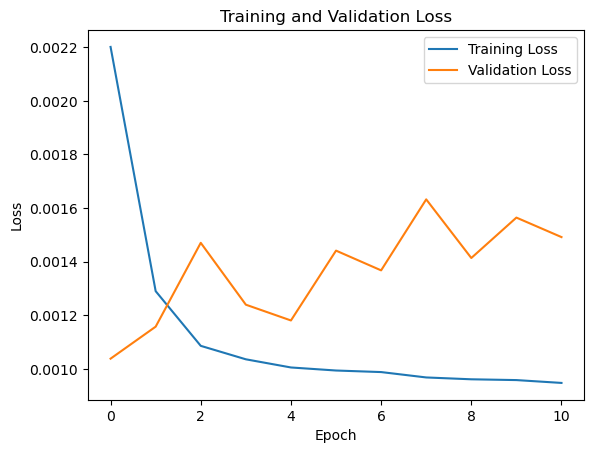

In [35]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1127/1127 [==============================] - 1s 520us/step


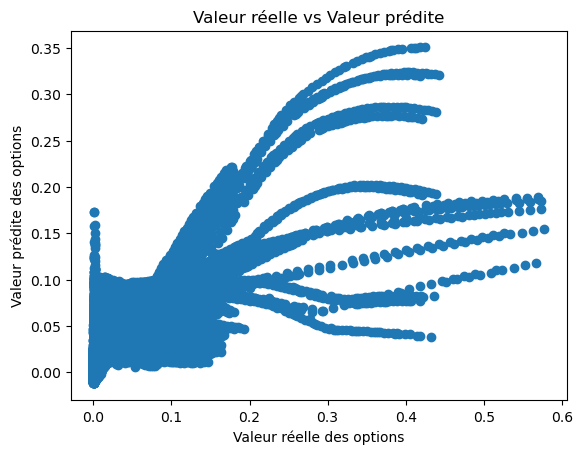

In [36]:
# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Tracer un graphique de la valeur réelle par rapport à la valeur prédite
plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [37]:
def fraction_in_spread(y_pred, y_test_ask, y_test_bid):
  count=0
  for i in range(len(y_pred)):
    if y_pred[i] <= y_test_ask[i] and y_pred[i] >= y_test_bid[i]:
      count+=1

  return count / len(y_test)

In [38]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 1.14%


In [39]:
def mean_squared_error(y_true, y_pred):
    squared_errors = (y_true - y_pred) ** 2
    mse = np.mean(squared_errors)
    return mse

In [40]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.001748840167774644


## Avec deux architectures plus complexes

In [41]:
def build_big_model(input_shape):
    model = Sequential([
        Dense(X_train.shape[1], activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(5000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(500, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

model = build_big_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 43s 18ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 2/500
2366/2366 [==============================] - 42s 18ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 3/500
2366/2366 [==============================] - 43s 18ms/step - loss: 0.0011 - val_loss: 0.0019
Epoch 4/500
2366/2366 [==============================] - 43s 18ms/step - loss: 0.0010 - val_loss: 0.0017
Epoch 5/500
2366/2366 [==============================] - 42s 18ms/step - loss: 9.6780e-04 - val_loss: 0.0017
Epoch 6/500
2366/2366 [==============================] - 44s 19ms/step - loss: 9.2588e-04 - val_loss: 0.0011
Epoch 7/500
2366/2366 [==============================] - 43s 18ms/step - loss: 9.1742e-04 - val_loss: 0.0014
Epoch 8/500
2366/2366 [==============================] - 43s 18ms/step - loss: 8.7486e-04 - val_loss: 0.0016
Epoch 9/500
2366/2366 [==============================] - 43s 18ms/step - loss: 8.6208e-04 - val_loss: 0.0016
Epoch 10/500
2366/2366 [===========

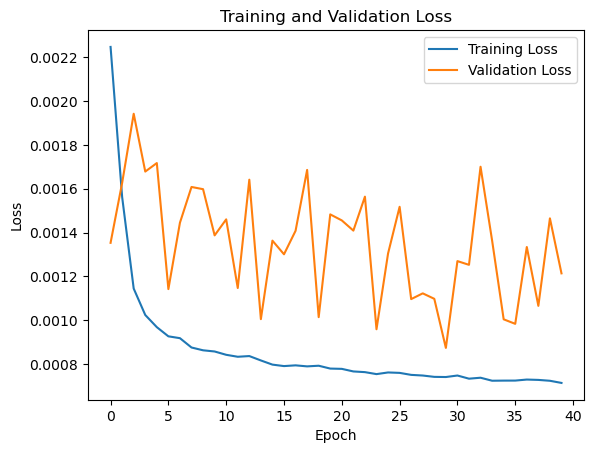

In [42]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1127/1127 [==============================] - 6s 5ms/step


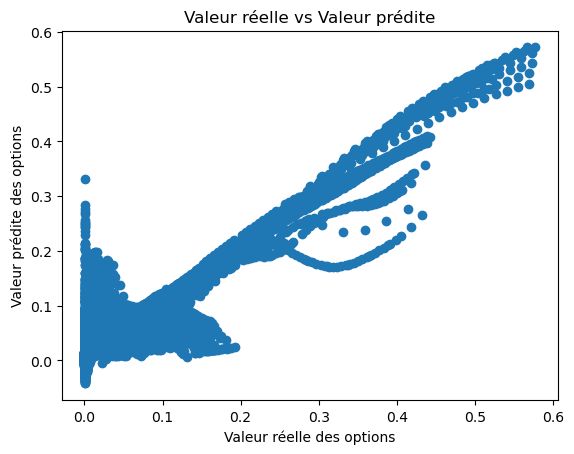

In [43]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [44]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 1.99%


In [45]:
y_pred = model.predict(X_test)

1127/1127 [==============================] - 6s 5ms/step


In [46]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.006966877566319382


### Structure en losange

In [47]:
def build_diamond_model(input_shape):
    model = Sequential([
        Dense(X_train.shape[1], activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(1500, activation='relu'),
        Dense(3500, activation='relu'),
        Dense(1500, activation='relu'),
        Dense(1, activation='linear')
    ])
    return model

model = build_diamond_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 75s 32ms/step - loss: 0.0023 - val_loss: 9.7011e-04
Epoch 2/500
2366/2366 [==============================] - 85s 36ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 3/500
2366/2366 [==============================] - 74s 31ms/step - loss: 0.0011 - val_loss: 8.7917e-04
Epoch 4/500
2366/2366 [==============================] - 71s 30ms/step - loss: 9.8822e-04 - val_loss: 0.0012
Epoch 5/500
2366/2366 [==============================] - 71s 30ms/step - loss: 9.3978e-04 - val_loss: 0.0016
Epoch 6/500
2366/2366 [==============================] - 71s 30ms/step - loss: 9.0350e-04 - val_loss: 0.0015
Epoch 7/500
2366/2366 [==============================] - 77s 33ms/step - loss: 8.8621e-04 - val_loss: 0.0017
Epoch 8/500
2366/2366 [==============================] - 73s 31ms/step - loss: 8.4652e-04 - val_loss: 0.0016
Epoch 9/500
2366/2366 [==============================] - 76s 32ms/step - loss: 8.3774e-04 - val_loss: 0.0012
Epoch 10/500
2366/2366 

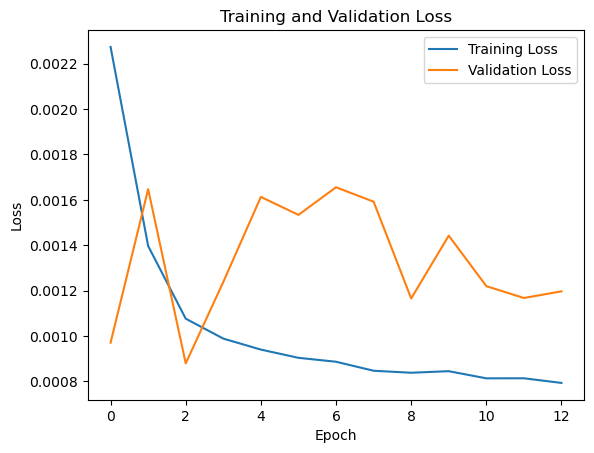

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1127/1127 [==============================] - 9s 8ms/step


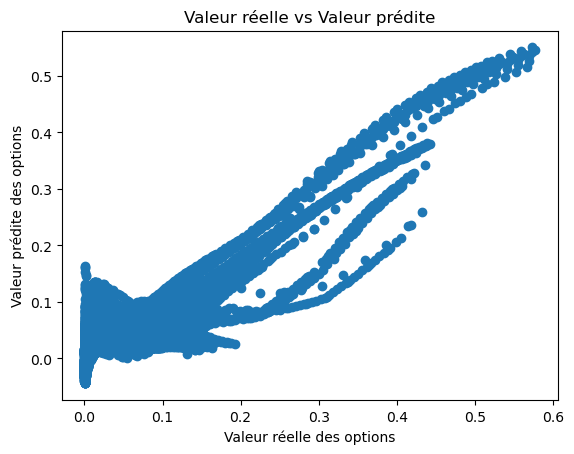

In [49]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [50]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 1.14%


In [51]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.0009056929883383568


# 2. Paramètres incomplets + spread relatif + mesure de volaitlité

In [52]:
X = merged[['strike_scaled', 'days_to_expiry', 'spread_scaled', "vol_measure"]].iloc[7:]

y = merged['mid_option'] / merged['mid']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

indices = X.index

train_indices = indices[:int(0.7 * len(indices))]
test_indices = indices[int(0.7 * len(indices)):]

X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_test, y_test = X.loc[test_indices], y.loc[test_indices]

### Modèle simple

In [53]:
model = build_simple_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history2 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 2s 711us/step - loss: 0.0042 - val_loss: 0.0027
Epoch 2/500
2366/2366 [==============================] - 2s 675us/step - loss: 0.0032 - val_loss: 0.0016
Epoch 3/500
2366/2366 [==============================] - 2s 725us/step - loss: 0.0030 - val_loss: 0.0018
Epoch 4/500
2366/2366 [==============================] - 1s 633us/step - loss: 0.0028 - val_loss: 0.0033
Epoch 5/500
2366/2366 [==============================] - 1s 579us/step - loss: 0.0028 - val_loss: 0.0015
Epoch 6/500
2366/2366 [==============================] - 1s 586us/step - loss: 0.0027 - val_loss: 0.0015
Epoch 7/500
2366/2366 [==============================] - 1s 628us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/500
2366/2366 [==============================] - 1s 608us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 9/500
2366/2366 [==============================] - 1s 605us/step - loss: 0.0026 - val_loss: 0.0015
Epoch 10/500
2366/2366 [==============================]

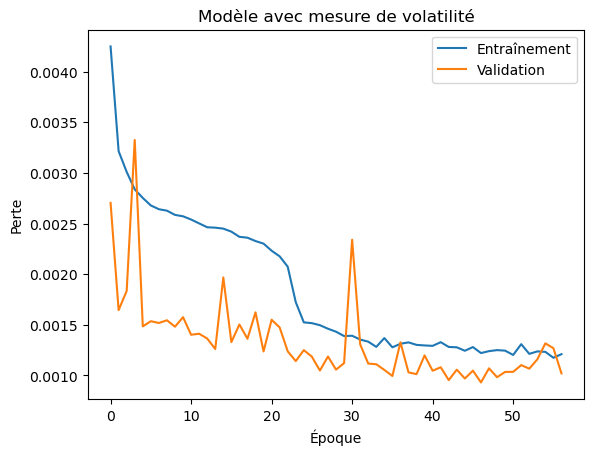

In [54]:
plt.plot(history2.history['loss'], label='Entraînement')
plt.plot(history2.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

1127/1127 [==============================] - 1s 538us/step


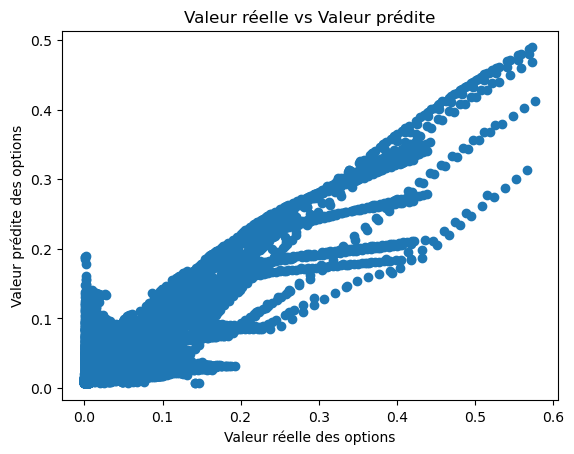

In [55]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [56]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 1.32%


In [57]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.0009598999089116508


## Avec les deux architectures plus complexes

In [58]:
model = build_big_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history2 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 42s 18ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 2/500
2366/2366 [==============================] - 43s 18ms/step - loss: 0.0033 - val_loss: 0.0016
Epoch 3/500
2366/2366 [==============================] - 43s 18ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 4/500
2366/2366 [==============================] - 42s 18ms/step - loss: 0.0027 - val_loss: 0.0014
Epoch 5/500
2366/2366 [==============================] - 42s 18ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 6/500
2366/2366 [==============================] - 42s 18ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 7/500
2366/2366 [==============================] - 45s 19ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 8/500
2366/2366 [==============================] - 45s 19ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/500
2366/2366 [==============================] - 44s 19ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/500
2366/2366 [==============================]

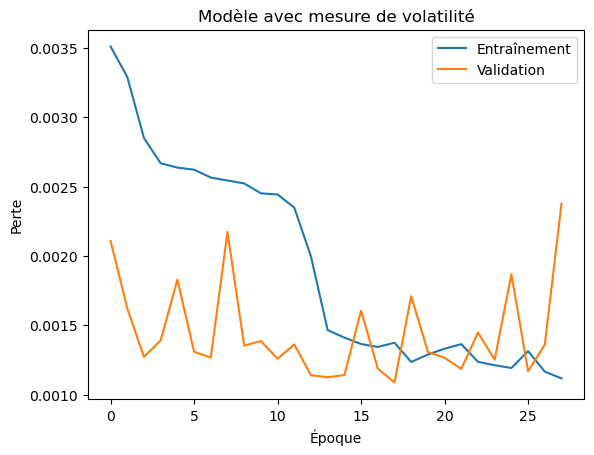

In [59]:
plt.plot(history2.history['loss'], label='Entraînement')
plt.plot(history2.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

1127/1127 [==============================] - 6s 5ms/step


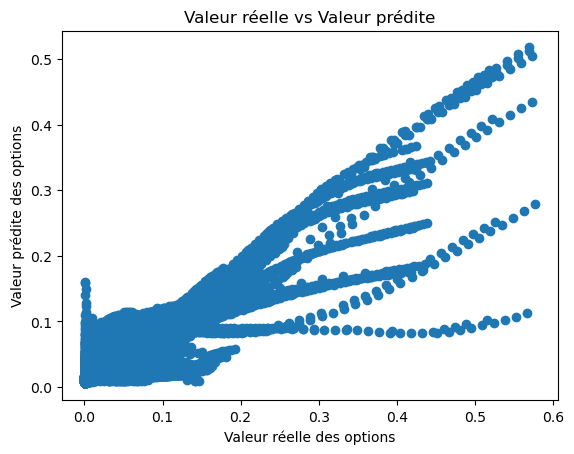

In [60]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [61]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 1.32%


In [62]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.0012332358410852469


### Structure en losange

In [63]:
model = build_diamond_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')


history2 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 2/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 3/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 4/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0032 - val_loss: 0.0016
Epoch 5/500
2366/2366 [==============================] - 74s 31ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 6/500
2366/2366 [==============================] - 74s 31ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 7/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 8/500
2366/2366 [==============================] - 74s 31ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 9/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0025 - val_loss: 0.0013
Epoch 10/500
2366/2366 [==============================]

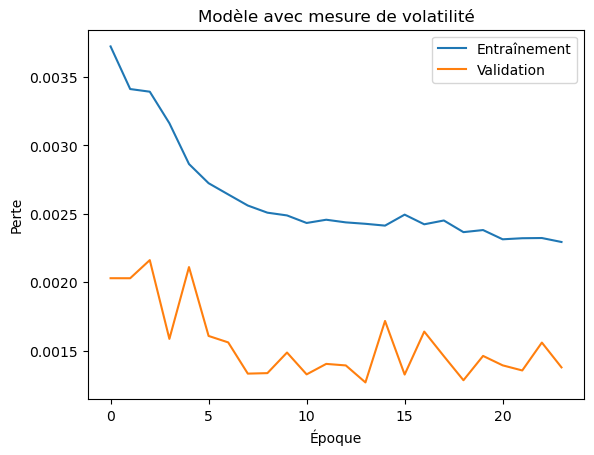

In [64]:
plt.plot(history2.history['loss'], label='Entraînement')
plt.plot(history2.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

1127/1127 [==============================] - 5s 4ms/step


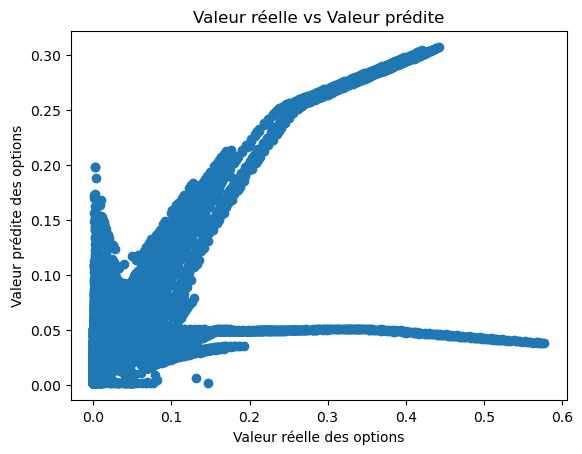

In [65]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [66]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 3.77%


In [67]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.0023217738824726246


### La mesure de volatilité du SP500 ne semble pas améliorer les résultats. Nous faisons donc le choix de la supprimer dans ce qui suit.

# 3. Paramètres incomplets + spread relatif + mesure de volatilité + Black and Scholes

In [233]:
merged["bs"] = 0
for i in tqdm(range(len(merged["mid"]))):
  if merged["option_type"].iloc[i] == "call":
    merged["bs"].iloc[i] = black_scholes_call(merged["mid"].iloc[i], merged["strike"].iloc[i], merged["days_to_expiry"].iloc[i] / 252, 0, merged["vol_measure"].iloc[i])/merged["mid"].iloc[i]
  else:
    merged["bs"].iloc[i] = black_scholes_put(merged["mid"].iloc[i], merged["strike"].iloc[i], merged["days_to_expiry"].iloc[i] / 252, 0, merged["vol_measure"].iloc[i])/merged["mid"].iloc[i]

  0%|                                                | 0/120153 [00:00<?, ?it/s]/var/folders/k9/dxv361v960vf9vbs06s2wdp80000gn/T/ipykernel_29138/34980576.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged["bs"].iloc[i] = black_scholes_call(merged["mid"].iloc[i], merged["strike"].iloc[i], merged["days_to_expiry"].iloc[i] / 252, 0, merged["vol_measure"].iloc[i])/merged["mid"].iloc[i]
100%|█████████████████████████████████| 120153/120153 [00:20<00:00, 5731.16it/s]


In [234]:
X = merged[['strike_scaled', 'days_to_expiry', 'spread_scaled', "vol_measure", "bs"]].iloc[7:]

y = merged['mid_option'] / merged['mid']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

indices = X.index

train_indices = indices[:int(0.7 * len(indices))]
test_indices = indices[int(0.7 * len(indices)):]

X_train, y_train = X.loc[train_indices], y.loc[train_indices]
X_test, y_test = X.loc[test_indices], y.loc[test_indices]

### Modèle simple

In [70]:
model = build_simple_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history3 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 1s 295us/step - loss: 0.0038 - val_loss: 0.0025
Epoch 2/500
2366/2366 [==============================] - 1s 277us/step - loss: 0.0021 - val_loss: 1.2532e-04
Epoch 3/500
2366/2366 [==============================] - 1s 276us/step - loss: 2.1768e-04 - val_loss: 1.0123e-04
Epoch 4/500
2366/2366 [==============================] - 1s 276us/step - loss: 2.0333e-04 - val_loss: 2.0362e-04
Epoch 5/500
2366/2366 [==============================] - 1s 276us/step - loss: 1.7830e-04 - val_loss: 1.1117e-04
Epoch 6/500
2366/2366 [==============================] - 1s 276us/step - loss: 1.7732e-04 - val_loss: 8.7230e-05
Epoch 7/500
2366/2366 [==============================] - 1s 276us/step - loss: 1.7357e-04 - val_loss: 1.5270e-04
Epoch 8/500
2366/2366 [==============================] - 1s 276us/step - loss: 1.6600e-04 - val_loss: 1.3424e-04
Epoch 9/500
2366/2366 [==============================] - 1s 276us/step - loss: 1.5421e-04 - val_loss: 1.4233

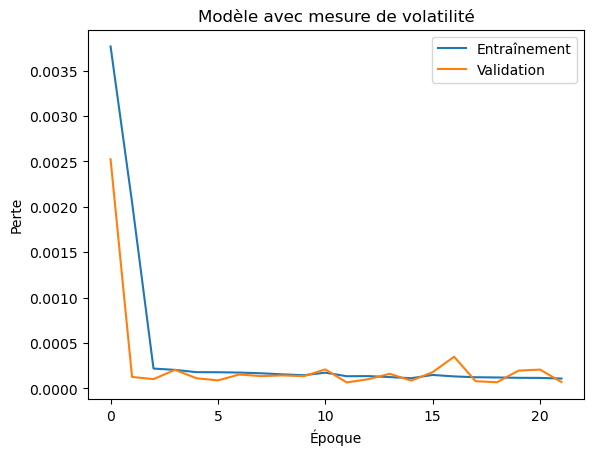

In [71]:
plt.plot(history3.history['loss'], label='Entraînement')
plt.plot(history3.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

1127/1127 [==============================] - 0s 199us/step


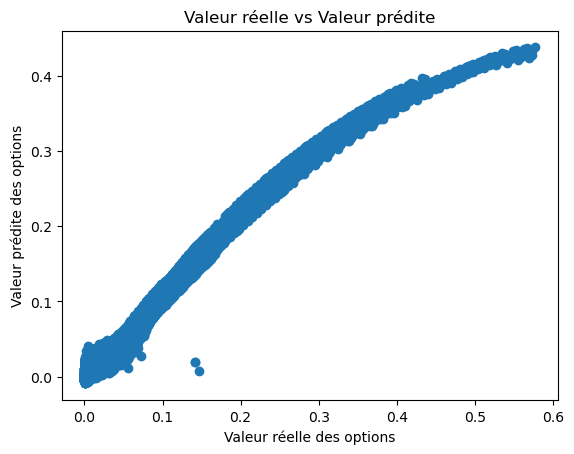

In [72]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [73]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.0068238679435983505


In [74]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 6.54%


### Modèles plus complexes

In [75]:
model = build_big_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history3 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 25s 10ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 2/500
2366/2366 [==============================] - 24s 10ms/step - loss: 8.7996e-04 - val_loss: 2.8944e-04
Epoch 3/500
2366/2366 [==============================] - 24s 10ms/step - loss: 2.5202e-04 - val_loss: 1.2060e-04
Epoch 4/500
2366/2366 [==============================] - 24s 10ms/step - loss: 1.8407e-04 - val_loss: 1.8773e-04
Epoch 5/500
2366/2366 [==============================] - 24s 10ms/step - loss: 1.6458e-04 - val_loss: 1.0983e-04
Epoch 6/500
2366/2366 [==============================] - 24s 10ms/step - loss: 1.5141e-04 - val_loss: 7.8683e-05
Epoch 7/500
2366/2366 [==============================] - 24s 10ms/step - loss: 1.5361e-04 - val_loss: 1.6525e-04
Epoch 8/500
2366/2366 [==============================] - 27s 11ms/step - loss: 1.5154e-04 - val_loss: 7.2338e-05
Epoch 9/500
2366/2366 [==============================] - 28s 12ms/step - loss: 1.3869e-04 - val_loss: 6.

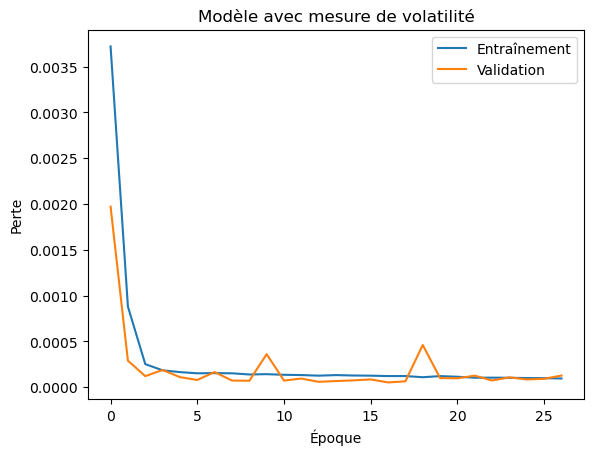

In [76]:
plt.plot(history3.history['loss'], label='Entraînement')
plt.plot(history3.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

1127/1127 [==============================] - 3s 2ms/step


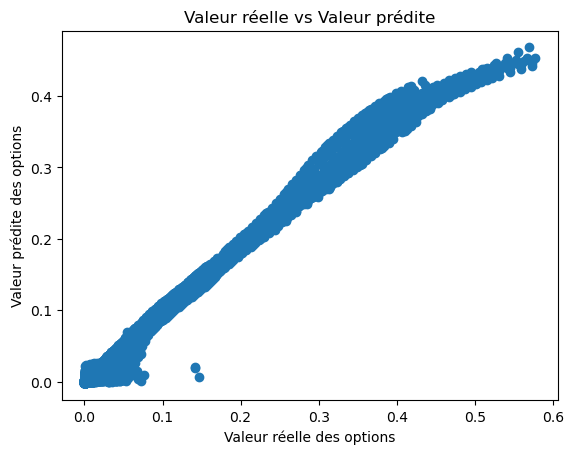

In [77]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [78]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.006545212767566044


In [79]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 8.76%


### Modèle losange

In [238]:
model = build_diamond_model(X_train.shape)

model.compile(optimizer='adam', loss='mean_squared_error')

history3 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Epoch 1/500
2366/2366 [==============================] - 124s 52ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 2/500
2366/2366 [==============================] - 76s 32ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 3/500
2366/2366 [==============================] - 75s 32ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 4/500
2366/2366 [==============================] - 73s 31ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 5/500
2366/2366 [==============================] - 64s 27ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 6/500
2366/2366 [==============================] - 78s 33ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 7/500
2366/2366 [==============================] - 64s 27ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/500
2366/2366 [==============================] - 64s 27ms/step - loss: 0.0034 - val_loss: 0.0023
Epoch 9/500
2366/2366 [==============================] - 64s 27ms/step - loss: 0.0034 - val_loss: 0.0022
Epoch 10/500
2366/2366 [==============================

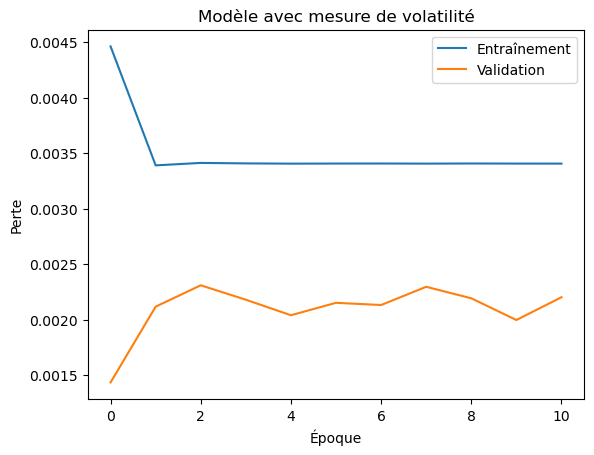

In [239]:
plt.plot(history3.history['loss'], label='Entraînement')
plt.plot(history3.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

1127/1127 [==============================] - 8s 7ms/step


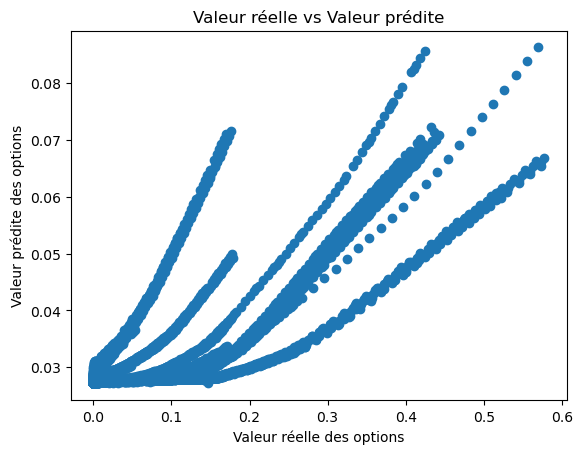

In [240]:
y_pred = model.predict(X_test)

plt.scatter(y_test.values, y_pred)
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [241]:
print(f"MSE {mean_squared_error(y_test.values, y_pred)}")

MSE 0.00356221707899446


In [242]:
y_pred = y_pred.flatten()
y_test_ask = merged["ask_scaled"].loc[test_indices].values
y_test_bid = merged["bid_scaled"].loc[test_indices].values

metric = fraction_in_spread(y_pred, y_test_ask, y_test_bid)
print(f'Fraction des prédictions dans le spread : {metric:.2%}')

Fraction des prédictions dans le spread : 0.73%


# 4. Parité Call-Put

In [200]:
def align_dataframes(calls, puts):
    aligned_calls = []
    aligned_puts = []

    for idx, call_row in calls.iterrows():
        put_row = puts[(puts['strike_scaled'] == call_row['strike_scaled']) & 
                        (puts['days_to_expiry'] == call_row['days_to_expiry'])]

        if not put_row.empty:
            aligned_calls.append(call_row)
            aligned_puts.append(put_row.iloc[0])

    aligned_calls_df = pd.DataFrame(aligned_calls)
    aligned_puts_df = pd.DataFrame(aligned_puts)
    return aligned_calls_df, aligned_puts_df

In [204]:
aligned_calls_df, aligned_puts_df = align_dataframes(calls, puts)

calls = aligned_calls_df
puts = aligned_puts_df

print(puts.index)
print(calls.index)

#calls.reset_index(inplace=True)
#puts.reset_index(inplace=True)


X_call = calls[['strike_scaled', 'days_to_expiry', 'spread_scaled', "vol_measure", "bs"]]
X_put = puts[['strike_scaled', 'days_to_expiry', 'spread_scaled', "vol_measure", "bs"]]

X_call.index = np.arange(len(X_call))
X_put.index = np.arange(len(X_put))

y_calls = calls['mid_option'] / calls['mid']
y_puts = puts['mid_option'] / puts['mid']
y_calls.index = np.arange(len(y_calls))
y_puts.index = np.arange(len(y_puts))

scaler = StandardScaler()
X_call = scaler.fit_transform(X_call)
scaler = StandardScaler()
X_put = scaler.fit_transform(X_put)

indices = np.arange(len(y_calls))

ratio = int(0.7 * len(indices))

y_train = np.column_stack((y_calls[:ratio], y_puts[:ratio]))
y_test = np.column_stack((y_calls[ratio:], y_puts[ratio:]))

X_train = np.column_stack((X_call[:ratio], X_put[:ratio]))
X_test = np.column_stack((X_call[ratio:], X_put[ratio:]))

Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       24813, 24814, 24815, 24816, 24817, 24818, 24819, 24820, 24821, 24822],
      dtype='int64', length=24823)
Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,     9,
       ...
       24813, 24814, 24815, 24816, 24817, 24818, 24819, 24820, 24821, 24822],
      dtype='int64', length=24823)


In [205]:
S = calls['mid'] / calls['mid']
K = calls['strike_scaled']
S_minus_K = S - K

In [206]:
y_train = np.column_stack((y_calls[:ratio], y_puts[:ratio], S_minus_K[:ratio]))
y_test = np.column_stack((y_calls[ratio:], y_puts[ratio:], S_minus_K[ratio:]))

# Define a simple neural network architecture for regression
def build_simple_model2(input_shape):
    model = Sequential([
        Dense(X_train.shape[1], activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(20, activation='relu'),
        Dense(10, activation='relu'),
        Dense(2)
    ])
    return model

def build_big_model2(input_shape):
    model = Sequential([
        Dense(X_train.shape[1], activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(5000, activation='relu'),
        Dense(1000, activation='relu'),
        Dense(500, activation='relu'),
        Dense(2, activation='linear')
    ])
    return model

def build_diamond_model2(input_shape):
    model = Sequential([
        Dense(X_train.shape[1], activation='sigmoid', input_shape=(X_train.shape[1],)),
        Dense(1500, activation='relu'),
        Dense(3500, activation='relu'),
        Dense(1500, activation='relu'),
        Dense(2, activation='linear')
    ])
    return model


def put_call_parity_loss(y_true, y_pred):
    # Extraire les prix de call et put prédits
    call_true, put_true = y_true[:, 0], y_true[:, 1]
    call_pred, put_pred = y_pred[:, 0], y_pred[:, 1]

    S_minus_K = y_true[:, 2]

    # Calculer la différence prédite entre call et put
    predicted_difference = call_pred - put_pred

    # Calculer la MSE pour la parité put-call
    parity_mse = tf.reduce_mean(tf.square(predicted_difference - S_minus_K))

    # Calculer la MSE pour les prix réels
    price_call_mse = tf.reduce_mean(tf.square(call_true - call_pred))
    price_put_mse = tf.reduce_mean(tf.square(put_true - put_pred))

    # Combiner les deux composantes de la perte
    combined_loss = price_call_mse + price_put_mse + parity_mse

    return combined_loss

input_shape = 5*2

print(np.shape(y_train))

# Build the model
model = build_simple_model2(input_shape)

# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=0.01), loss=put_call_parity_loss)

# Summary of the model
model.summary()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entraînement du modèle
history4 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, shuffle=True, callbacks=[early_stopping])

(17376, 3)


Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_136 (Dense)           (None, 10)                110       
                                                                 
 dense_137 (Dense)           (None, 20)                220       
                                                                 
 dense_138 (Dense)           (None, 10)                210       
                                                                 
 dense_139 (Dense)           (None, 2)                 22        
                                                                 
Total params: 562 (2.20 KB)
Trainable params: 562 (2.20 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
435/435 [==============================] - 1s 1ms/step - loss: 0.0010 - val_loss: 1.6789e-04
Epoch 2/500
435/435 [=============================

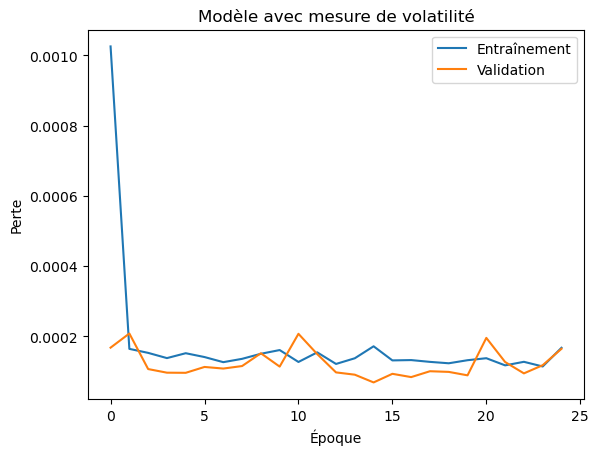

In [207]:
plt.plot(history4.history['loss'], label='Entraînement')
plt.plot(history4.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

233/233 [==============================] - 0s 683us/step


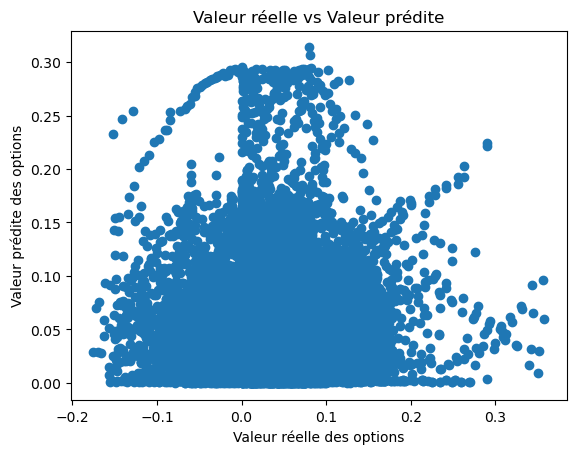

In [208]:
y_pred = model.predict(X_test)

plt.scatter(y_test.flatten()[:len(y_pred.flatten())], y_pred.flatten())
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

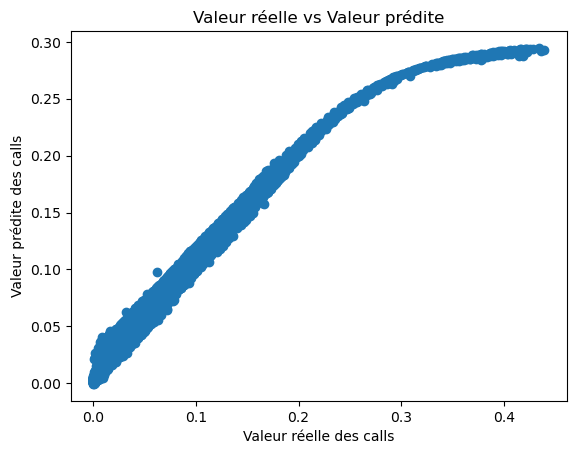

In [209]:
plt.scatter(y_test[:, 0], y_pred[:, 0])
plt.xlabel('Valeur réelle des calls')
plt.ylabel('Valeur prédite des calls')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

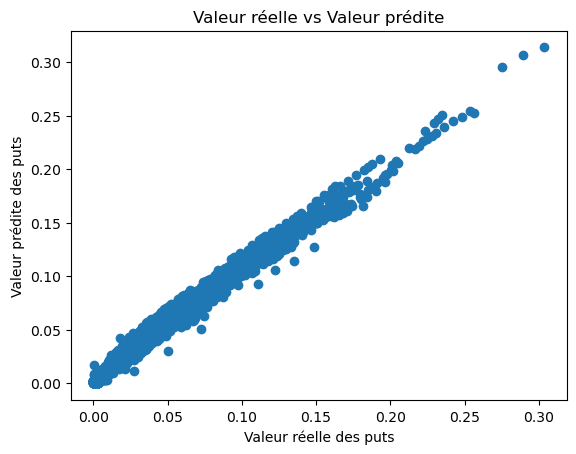

In [210]:
plt.scatter(y_test[:, 1], y_pred[:, 1])
plt.xlabel('Valeur réelle des puts')
plt.ylabel('Valeur prédite des puts')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [213]:
y_test_ask = calls["ask_scaled"].loc[ratio:].values
y_test_bid = calls["bid_scaled"].loc[ratio:].values

metric = fraction_in_spread(y_pred[:, 0], y_test_ask, y_test_bid)
print(f'Fraction des prédictions de calls dans le spread : {metric:.2%}')

y_test_ask = puts["ask_scaled"].loc[ratio:].values
y_test_bid = puts["bid_scaled"].loc[ratio:].values

metric = fraction_in_spread(y_pred[:, 1], y_test_ask, y_test_bid)
print(f'Fraction des prédictions de puts dans le spread : {metric:.2%}')

Fraction des prédictions de calls dans le spread : 4.81%
Fraction des prédictions de puts dans le spread : 5.69%


In [214]:
# Build the model
model = build_big_model2(input_shape)

# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=0.01), loss=put_call_parity_loss)

# Summary of the model
model.summary()

# Entraînement du modèle
history4 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_145 (Dense)           (None, 10)                110       
                                                                 
 dense_146 (Dense)           (None, 5000)              55000     
                                                                 
 dense_147 (Dense)           (None, 1000)              5001000   
                                                                 
 dense_148 (Dense)           (None, 500)               500500    
                                                                 
 dense_149 (Dense)           (None, 2)                 1002      
                                                                 
Total params: 5557612 (21.20 MB)
Trainable params: 5557612 (21.20 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500
4

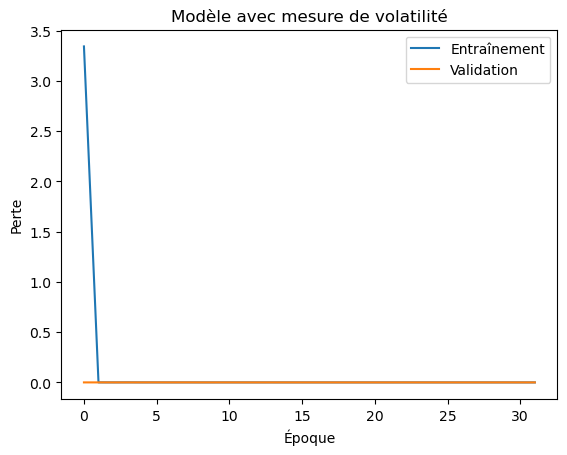

In [215]:
plt.plot(history4.history['loss'], label='Entraînement')
plt.plot(history4.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

233/233 [==============================] - 1s 5ms/step


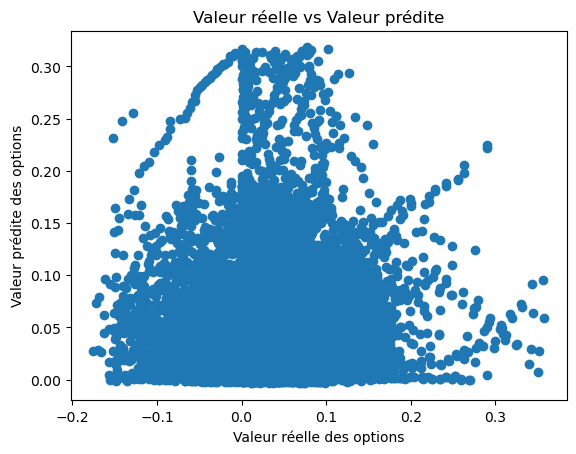

In [216]:
y_pred = model.predict(X_test)

plt.scatter(y_test.flatten()[:len(y_pred.flatten())], y_pred.flatten())
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

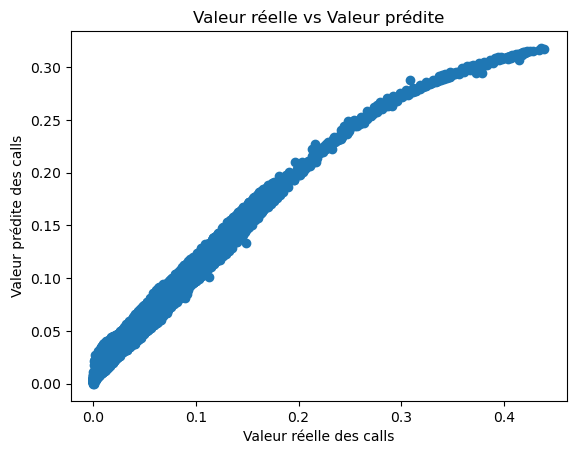

In [217]:
plt.scatter(y_test[:, 0], y_pred[:, 0])
plt.xlabel('Valeur réelle des calls')
plt.ylabel('Valeur prédite des calls')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

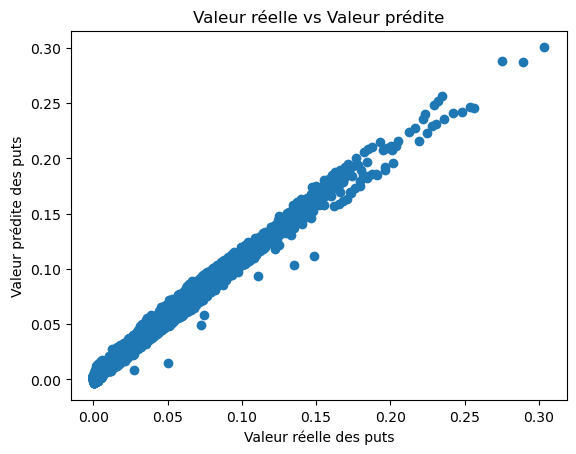

In [218]:
plt.scatter(y_test[:, 1], y_pred[:, 1])
plt.xlabel('Valeur réelle des puts')
plt.ylabel('Valeur prédite des puts')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [219]:
y_test_ask = calls["ask_scaled"].loc[ratio:].values
y_test_bid = calls["bid_scaled"].loc[ratio:].values

metric = fraction_in_spread(y_pred[:, 0], y_test_ask, y_test_bid)
print(f'Fraction des prédictions de calls dans le spread : {metric:.2%}')

y_test_ask = puts["ask_scaled"].loc[ratio:].values
y_test_bid = puts["bid_scaled"].loc[ratio:].values

metric = fraction_in_spread(y_pred[:, 1], y_test_ask, y_test_bid)
print(f'Fraction des prédictions de puts dans le spread : {metric:.2%}')

Fraction des prédictions de calls dans le spread : 5.17%
Fraction des prédictions de puts dans le spread : 5.09%


In [220]:
# Build the model
model = build_diamond_model2(input_shape)

# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=0.01), loss=put_call_parity_loss)

# Summary of the model
model.summary()

# Entraînement du modèle
history4 = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.1, shuffle=True, callbacks=[early_stopping])

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_150 (Dense)           (None, 10)                110       
                                                                 
 dense_151 (Dense)           (None, 1500)              16500     
                                                                 
 dense_152 (Dense)           (None, 3500)              5253500   
                                                                 
 dense_153 (Dense)           (None, 1500)              5251500   
                                                                 
 dense_154 (Dense)           (None, 2)                 3002      
                                                                 
Total params: 10524612 (40.15 MB)
Trainable params: 10524612 (40.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/500

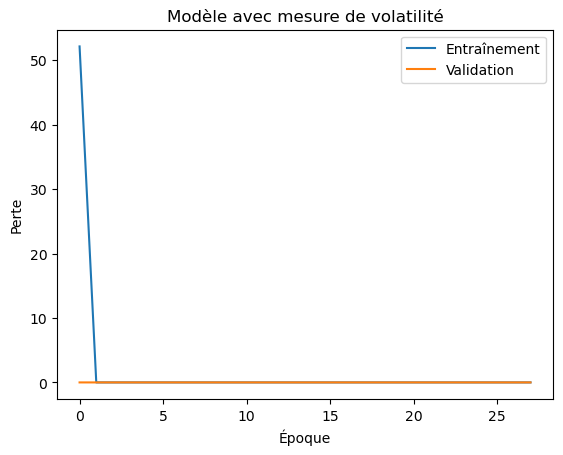

In [221]:
plt.plot(history4.history['loss'], label='Entraînement')
plt.plot(history4.history['val_loss'], label='Validation')
plt.xlabel('Époque')
plt.ylabel('Perte')
plt.legend()
plt.title("Modèle avec mesure de volatilité")
plt.show()

233/233 [==============================] - 3s 10ms/step


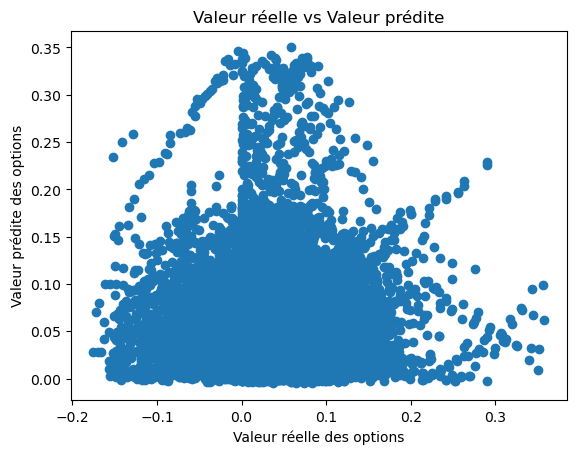

In [222]:
y_pred = model.predict(X_test)

plt.scatter(y_test.flatten()[:len(y_pred.flatten())], y_pred.flatten())
plt.xlabel('Valeur réelle des options')
plt.ylabel('Valeur prédite des options')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

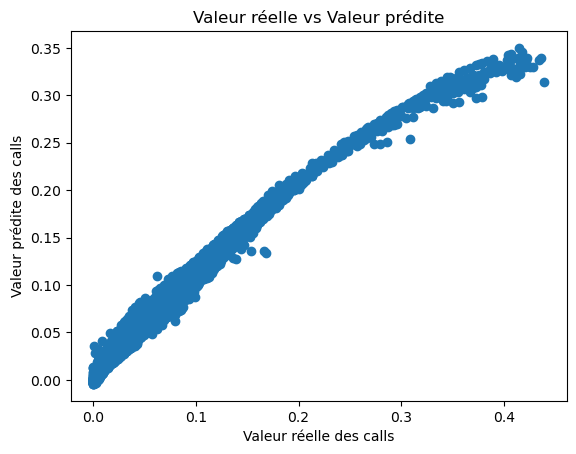

In [223]:
plt.scatter(y_test[:, 0], y_pred[:, 0])
plt.xlabel('Valeur réelle des calls')
plt.ylabel('Valeur prédite des calls')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

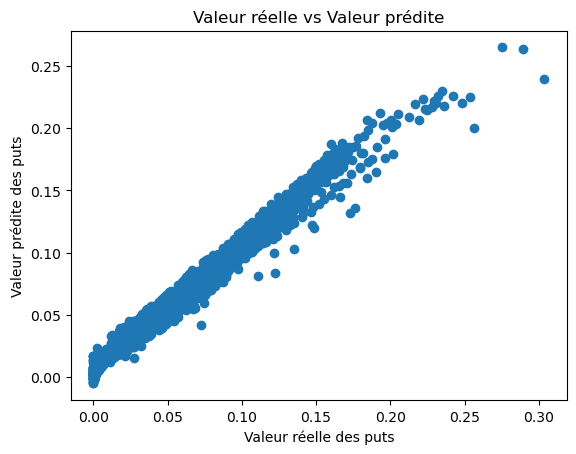

In [224]:
plt.scatter(y_test[:, 1], y_pred[:, 1])
plt.xlabel('Valeur réelle des puts')
plt.ylabel('Valeur prédite des puts')
plt.title('Valeur réelle vs Valeur prédite')
plt.show()

In [225]:
y_test_ask = calls["ask_scaled"].loc[ratio:].values
y_test_bid = calls["bid_scaled"].loc[ratio:].values

metric = fraction_in_spread(y_pred[:, 0], y_test_ask, y_test_bid)
print(f'Fraction des prédictions de calls dans le spread : {metric:.2%}')

y_test_ask = puts["ask_scaled"].loc[ratio:].values
y_test_bid = puts["bid_scaled"].loc[ratio:].values

metric = fraction_in_spread(y_pred[:, 1], y_test_ask, y_test_bid)
print(f'Fraction des prédictions de puts dans le spread : {metric:.2%}')

Fraction des prédictions de calls dans le spread : 1.53%
Fraction des prédictions de puts dans le spread : 10.85%
